In [1]:
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing import image, image_dataset_from_directory
from keras.models import Sequential, Model
from keras.optimizers import Adam
from focal_loss import BinaryFocalLoss
from keras.layers import Dense, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import classification_report, confusion_matrix
from focal_loss import BinaryFocalLoss
import pandas as pd
import os

In [2]:
train=pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/train.csv')
train = train.fillna(0)
# import valid data info from valid.csv
valid=pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/valid.csv')
valid = valid.fillna(0)

valid = valid.append(valid)

#pre-process data: remove Lateral images
train = train[~train[train.columns[3]].str.contains("Lateral")]

#pre-process data: drop selected features - only images as inputs
train = train.filter(["Path", "No Finding"], axis=1)
train['No Finding'] = train['No Finding'].astype(str)
print(train.shape)
train.head(20)

(191027, 2)


,Path,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,1.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,0.0
5,CheXpert-v1.0/train/patient00004/study1/view1_...,1.0
7,CheXpert-v1.0/train/patient00005/study1/view1_...,1.0
9,CheXpert-v1.0/train/patient00005/study2/view1_...,0.0
10,CheXpert-v1.0/train/patient00005/study2/view2_...,0.0
11,CheXpert-v1.0/train/patient00006/study1/view1_...,1.0
12,CheXpert-v1.0/train/patient00007/study1/view1_...,0.0


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.4, random_state=1)
valid, test = train_test_split(test, test_size=.5, random_state=1)

In [4]:
IMAGE_WIDTH, IMAGE_HEIGHT = (456, 456)
EPOCHS = 50
BATCH_SIZE = 512
learning = 0.001
image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2
    )
valid_datagen = ImageDataGenerator(
        rescale=1./255
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='/home/jupyter-zaiman/data/DataCenter/',
    x_col="Path", y_col="No Finding", 
    class_mode="binary", 
    target_size=(456, 456), 
    batch_size=BATCH_SIZE)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid, directory='/home/jupyter-zaiman/data/DataCenter/', x_col="Path", y_col="No Finding", class_mode="binary", target_size=(224, 224), shuffle = True, batch_size=BATCH_SIZE)
test_generator=valid_datagen.flow_from_dataframe(dataframe=test, directory='/home/jupyter-zaiman/data/DataCenter/', x_col="Path", y_col="No Finding", class_mode="binary", target_size=(224, 224), shuffle = False, batch_size=BATCH_SIZE)

Found 114616 validated image filenames belonging to 2 classes.
Found 38205 validated image filenames belonging to 2 classes.
Found 38206 validated image filenames belonging to 2 classes.


In [6]:
# import efficientnet.keras as eff
def create_model():
    
    base = tf.keras.applications.EfficientNetB5(
        include_top=False,
        weights="imagenet",
            pooling='max',
        classes=2,
        classifier_activation="softmax",
        )
   
#     base = eff.EfficientNetB5(weights='noisy-student')
    for layer in base.layers:
        layer.trainable = False
    
    for layer in [l for l in base.layers if 'top' in l.name or 'block7' in l.name]:
           layer.trainable = True

    x = Flatten()(base.output)
    x = Dense(1024, activation = 'relu')(x)
    prediction = Dense(2, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=prediction)
    

    
    model.summary()
    return model

In [7]:
def train_base(model, train_ds, valid_ds):     
#     class_weights = class_weight.compute_class_weight(
#                'balanced',
#                 np.unique(train_ds.classes), 
#                 train_ds.classes
#     )
#     class_weights = {i : class_weights[i] for i in range(2)}
    model.compile(optimizer=Adam(lr=learning), loss=BinaryFocalLoss(gamma=2), 
                  metrics=['accuracy'])
    
    
    save = ModelCheckpoint(
        '/home/jupyter-zaiman/Efficient_Data/saves/', 
        monitor='val_accuracy', 
        save_best_only=True,
        save_weights_only=True, 
        mode='max',
        verbose=1
    )
    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
    scheduler = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.01,
        patience=3,
        verbose=1
    )
    logger = CSVLogger('/home/jupyter-zaiman/Efficient_Data/saves/noisystudent.log')
    history = model.fit(train_ds, 
        epochs=EPOCHS, 
#         steps_per_epoch=len(train_ds.filenames) // BATCH_SIZE, 
        validation_data=valid_ds, 
#         validation_steps=len(valid_ds.filenames) // BATCH_SIZE, 
        verbose=1, 
        callbacks=[scheduler, stop, save, logger]
    )
    model.save=('noisy-student.h5')
    return history
    



In [ ]:
def getMetrics(model, history):
    print(history.history.keys())
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='bottom right')
    plt.show()
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='bottom right')
    plt.show()
    
    
    Y_pred = model.predict(test_generator, len(test_generator.filenames))
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    target_names = ['Abnormal', 'Normal']
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [9]:
res = create_model()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_______________________________________________________________________________________

In [12]:
hist = train_base(res, train_generator, valid_generator)

Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 8.0368 - accuracy: 0.9078  
Epoch 00001: val_accuracy improved from -inf to 0.91137, saving model to /home/jupyter-zaiman/Efficient_Data/saves/
224/224 [==============================] - 23768s 106s/step - loss: 8.0368 - accuracy: 0.9078 - val_loss: 8.0590 - val_accuracy: 0.9114
Epoch 2/50
224/224 [==============================] - ETA: 0s - loss: 8.0591 - accuracy: 0.9114  
Epoch 00002: val_accuracy did not improve from 0.91137
224/224 [==============================] - 24319s 109s/step - loss: 8.0591 - accuracy: 0.9114 - val_loss: 8.0590 - val_accuracy: 0.9114
Epoch 3/50
224/224 [==============================] - ETA: 0s - loss: 8.0591 - accuracy: 0.9114  
Epoch 00003: val_accuracy did not improve from 0.91137
224/224 [==============================] - 23928s 107s/step - loss: 8.0591 - accuracy: 0.9114 - val_loss: 8.0590 - val_accuracy: 0.9114
Epoch 4/50
224/224 [==============================] - ETA: 0s - loss: 8.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


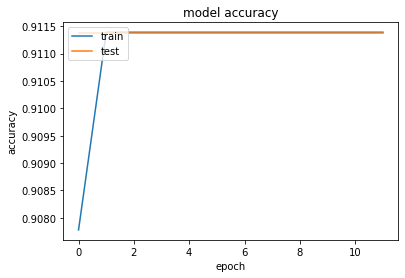

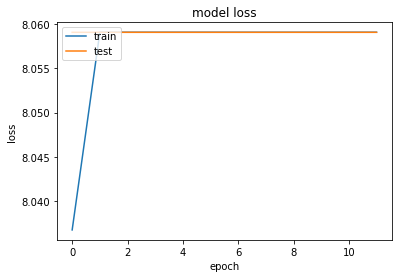

Confusion Matrix
[[34774     0]
 [ 3432     0]]
Classification Report
              precision    recall  f1-score   support

    Abnormal       0.91      1.00      0.95     34774
      Normal       0.00      0.00      0.00      3432

    accuracy                           0.91     38206
   macro avg       0.46      0.50      0.48     38206
weighted avg       0.83      0.91      0.87     38206



/home/jupyter-zaiman/.conda/envs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
getMetrics(res, hist)